# **FRASE assay - Data analysis**

The Fluorescence resonance energy transfer (FRET)-based mHTT aggregate seeding assay is a biophysical assay use to follow the aggregation of Huntingtin Exon 1 (HttEx1) during a time course. Besides of using this assay to study HttEx1 aggregation kinetics, it can also be used to assess the effect of inhibitors or the seeding activity of biological Htt samples.

It requires the two fluorescently-label proteins (GST-Ex1Q48-CyPet or GST-Ex1Q48-YPet) as decribed in:

[A. Ast, A. Buntru, F. Schindler, R. Hasenkopf, A.
Schulz, L. Brusendorf, K. Klockmeier, G. Grelle, B.
McMahon, H. Niederlechner, I. Jansen, L. Diez, J. Edel,
A. Boeddrich, S. A. Franklin, B. Baldo, S. Schnoegl,
S. Kunz, B. Purfurst, A. Gaertner, H. H. Kampinga,
A. J. Morton,  A. Petersen, J. Kirstein, G. P. Bates, and
E. E. Wanker. mhtt seeding activity: A marker of disease progression
and neurotoxicity in models of huntington’s disease. Molecular Cell, 71:675–
688.e6, 9 2018](https://www.sciencedirect.com/science/article/pii/S1097276518306014?via%3Dihub).

This script is designed to analyze FRASE data from this system using a 384-well reading plate and a Tecan reader.

It takes two files in .csv format:

1) The pippeting scheme, containing the scheme of the 384-well plate.

2) The raw data exported form the tecan in a .csv file.


In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess
import csv
from scipy.optimize import curve_fit
from tabulate import tabulate
import warnings

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
""" 
The pipetting scheme and the output sheet need to be exported as csv (comma separated values) files. Change the name of the .csv input file accordingly
"""
# Specify the csv file name containing the pipetting_scheme
pip_file = 'pipetting_scheme_template_cortex_Bates_FRASE.csv'

# Specify the csv file name containing the data
input_file = 'FRASE_Messung_08.08.24_mousebrain_cortex_bates.csv'


In [3]:
"""
Create a dictionary that contains information about the contents of each well. This will enable the script to recognize and track the substances you placed in each well during your experiment.
"""

# Create a dictionary with the pippeting scheme. This command read the CSV file skipping the first row
with open(pip_file, 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    data = list(reader)

# Initialize the dictionary to store field positions
my_exp = {}

# Iterate through the rows and columns to populate the dictionary
for row_index, row in enumerate(data):
    for col_index, field in enumerate(row[1:], start=1):  # Start from 1 to skip the first column
        row_label = chr(ord('A') + row_index)  # Convert row index to letter
        position = f"{row_label}{col_index}"

        # Check if the field is not empty and not a repeat
        if field and field not in my_exp:
            # If it's a new field, add it to the dictionary with an empty list
            my_exp[field] = []

        # If the field is not empty, add the position to its list
        if field:
            my_exp[field].append(position)

# Print the dictionary
#for key, value in my_exp.items():
#    print(f"{key}: {value}")
#print(my_exp['CyPet-only'])

# Create a new dictionary excluding specified keys - those that are not fret experiments
exclude_keys = ['Background', 'CyPet-only', 'YPet-only', 'Blank']
my_exp_filtered = {key: value for key, value in my_exp.items() if key not in exclude_keys}

# Print the filtered dictionary
#for key, value in my_exp_filtered.items():
#    print(f"{key}: {value}")

In [4]:
"""
Read the file and store the CyPet, yPet and FRET tables in separate csv files
"""

# This awk oneliner creates three separated csv files for CyPet, YPet and FRET
awk_command = fr'''awk -F, '/^CyPet/ {{ f = "CyPet.csv"; }} /^YPet/ {{ f = "YPet.csv"; }} /^FRET/ {{ f = "FRET.csv"; }} f {{ print > f; }}' {input_file}'''
result = subprocess.check_output(awk_command, shell=True, text=True)

In [5]:
"""
Read the tables from the corresponding csv files and store them in pandas dataframes
"""

variables = ['CyPet', 'YPet', 'FRET']

# Create an empty dictionary to store the raw dataframes
raw_df = {}

for i in variables:
    # Read the file
    df = pd.read_csv(f'{i}.csv', skiprows=1)
    # Transpose the DataFrame
    df = df.transpose()
    # Reset the header to the first row and remove the original header
    df.columns = df.iloc[0]
    df = df[1:]
    # Drop columns with NaN (null) header
    df = df.dropna(axis=1, how='all')
    # Delete Endzeit or End Time column in FRET. 
    if 'Endzeit:' in df.columns:
        df.drop('Endzeit:', axis=1, inplace=True)
    elif 'End Time:' in df.columns:
        df.drop('End Time:', axis=1, inplace=True)

    # Discard rows with null values
    df = df.dropna(axis=0)
    # Convert all the values in the dataframe to numerical values in case there are some unnoticed strings
    df = df.apply(pd.to_numeric, errors='coerce')
    # Save the DataFrame as a separate CSV file in a clean format (in case is needed)
    #df.to_csv(f'{i}_clean.csv', index=False)
    # Save the dataframe in the dictionary for later use
    raw_df[i] = df

# Concatenate all DataFrames in the dictionary
raw_df = pd.concat(raw_df.values(), axis=1, keys=raw_df.keys())
raw_df.to_csv('raw.csv', index=False)
#print(raw_df)

In [6]:
"""
Substract the background
"""

# Creates an empty dictionary to store the substracted dataframes
substracted_df = {}

# Extract the well corresponding to the background. This command will take only the first well (element 0) of the Background. Change it to 1 if you want to use the duplicate instead. 
bg = my_exp['Background'][0]

variables = ['CyPet', 'YPet', 'FRET']

for i in variables:
    
    # pull the dataframe from the dictionary
    my_df = raw_df[f'{i}']
    
    # List the columns of each data frame. 
    columns = list(my_df.columns.values)
    
    # Create a sublist of the list excluding the columns that correspond to time and Temperature.
    data_col = columns[2:]
    
    # Create a list to store the new dataframes
    substracted_dfs = []
    
    # Substract the bg from each column.
    for j in data_col:
        resta = raw_df[i][j] - raw_df[i][bg]
        substracted_dfs.append(pd.DataFrame({f'{j}': resta}))
    
    # Concatenate all the DataFrames along the columns (axis=1)
    substracted_df[f'{i}'] = pd.concat(substracted_dfs, axis=1)

substracted_df['CyPet'].to_csv('subs_cypet.csv', index=False)
substracted_df['YPet'].to_csv('subs_ypet.csv', index=False)
substracted_df['FRET'].to_csv('subs_fret.csv', index=False)


In [7]:
"""
Determine correction factor for CyPet and YPet
"""

# Extract the wells corresponding to CyPet and YPet only in my_exp. Assumes there is only one of them per experiment.
cypet_only = my_exp['CyPet-only'][0]
ypet_only = my_exp['YPet-only'][0]

# Gets the correction factor for each fluorophore. 
cypet_corrfac = np.mean(substracted_df['FRET'][cypet_only]/substracted_df['CyPet'][cypet_only])
ypet_corrfac = np.mean(substracted_df['FRET'][ypet_only]/substracted_df['YPet'][ypet_only])

#print(cypet_corrfac)
#print(ypet_corrfac)

In [8]:
"""
Obtaining False FRET
"""

# Create an empty dictionary to store the substracted dataframes excluding the background, the cypet-only and the ypet-only wells
two_fluo_df = {}

# Define the columns to exclude in the new dataframes
columns_to_exclude = my_exp['Background'] + my_exp['CyPet-only'] + my_exp['YPet-only']
#print(columns_to_exclude)

variables = ['CyPet', 'YPet', 'FRET']

for l in variables:
    two_fluo_df[f'{l}'] = substracted_df[f'{l}'].drop(columns=columns_to_exclude)
#print(two_fluo_df['FRET'])

# Get False Frate
false_fret = two_fluo_df['CyPet']*cypet_corrfac + two_fluo_df['YPet']*ypet_corrfac

#print(false_fret)
false_fret.to_csv('false.csv', index=False)


In [9]:
"""
Obtaining Real FRET
"""

# Define the data in my_exp that contains actual FRET experiments - with both fluorophores present
real_fret = two_fluo_df['FRET'] - false_fret

#print(real_fret)
real_fret.to_csv('real.csv', index=False)


In [10]:
"""
Obtaining Clean Normalized FRET. Discard "bad" data. Too many negative values and infinite values.
"""

# Define the data in my_exp that contains actual FRET experiments - with both fluorophores present
norm_fret = real_fret/two_fluo_df['YPet']*100

#print(norm_fret)
norm_fret.to_csv('norm.csv', index=False)


In [11]:

"""
Obtaining Clean Normalized FRET. Discard "bad" data. More than 20 negative values and infinite values.
"""

# Calculate normalized FRET
norm_fret = real_fret / two_fluo_df['YPet'] * 100

# Identify and discard columns with more than 20 negative values or any infinite values
columns_to_discard = []
negative_threshold = 20

for column in norm_fret.columns:
    negative_count = (norm_fret[column] < 0).sum()  # Count of negative values in the column
    has_infinite = np.isinf(norm_fret[column]).any()  # Check for infinite values

    # Discard columns with more than 20 negative values or any infinite values
    if negative_count > negative_threshold or has_infinite:
        columns_to_discard.append(column)

# Warn the user about discarded columns
if columns_to_discard:
    warnings.warn(f"Columns {', '.join(columns_to_discard)} were discarded because they contain more than {negative_threshold} negative values or infinite values.")

# Drop columns with more than 20 negative values or any infinite values
clean_norm_fret = norm_fret.drop(columns=columns_to_discard)

# Save the cleaned DataFrame to a CSV file
clean_norm_fret.to_csv('clean_norm_fret.csv', index=False)

# Optional: print or return the cleaned DataFrame if needed
#print(clean_norm_fret)

# Check if any of the discarded headers appear as values in `my_exp_filtered`
headers_in_values = []
for key, values in my_exp_filtered.items():
    for header in columns_to_discard:
        if header in values:
            headers_in_values.append(key)
            break  # No need to check further for this key

# Remove entries from `my_exp_filtered` where the discarded headers are found as values
cleaned_exp_filtered = {k: v for k, v in my_exp_filtered.items() if k not in headers_in_values}

# Warn the user about removed dictionary entries
if headers_in_values:
    warnings.warn(f"Entries {', '.join(headers_in_values)} were discarded from `my_exp_filtered` because they contained headers from invalid columns as values.")

# Print the final cleaned dictionary
#print(cleaned_exp_filtered)

/var/folders/y3/vtrq56zj6dg7pxbf704l5fr40000gn/T/ipykernel_57734/2142218204.py:22: UserWarning: Columns J4, K4, L4 were discarded because they contain more than 20 negative values or infinite values.
  warnings.warn(f"Columns {', '.join(columns_to_discard)} were discarded because they contain more than {negative_threshold} negative values or infinite values.")
/var/folders/y3/vtrq56zj6dg7pxbf704l5fr40000gn/T/ipykernel_57734/2142218204.py:46: UserWarning: Entries WT-6mon-19 were discarded from `my_exp_filtered` because they contained headers from invalid columns as values.
  warnings.warn(f"Entries {', '.join(headers_in_values)} were discarded from `my_exp_filtered` because they contained headers from invalid columns as values.")


In [21]:
"""
Separate triplicates. Get the mean and the standard deviation.
"""

# Creates an empty dictionary to store the data to save in cvs
#export_data = {}

# Creates an empty dataframe to store the data to plot
data_list = []

# Define the name of each FRASE experiment that was made by triplicates
exp_fret = list(cleaned_exp_filtered)

# Get the average of each triplicate and the standard deviation. 
for m in exp_fret:

    storem = [] # Empty list to store de data for each experiment
    col_to_include = my_exp[f'{m}']
    
    # Get the data for each triplicate
    for k in col_to_include:
        storem.append(pd.DataFrame({f'{k}':norm_fret[k]}))
    
    # Get the mean for each exp
    mean_data = clean_norm_fret[col_to_include].mean(axis=1)
    data_list.append(pd.DataFrame({f'{m}':mean_data}))
    storem.append(pd.DataFrame({f'mean_{m}':mean_data}))
    
    # Get the standard deviation
    sd_data = clean_norm_fret[col_to_include].std(axis=1)
    data_list.append(pd.DataFrame({f'std_{m}':sd_data}))
    storem.append(pd.DataFrame({f'std_{m}':sd_data}))
    
    # Replace conflicting character /
    m = m.replace('/', '_')
    
    # Concatenate the storem list containing information of each triplicate into a dataframe and save it as csv
    df = pd.concat(storem, axis=1)
    df.to_csv(f'data_{m}.csv', index=False)
    
# Concatenate all the means and sd in a dataframe named frase_plot
frase_plot = pd.concat(data_list, axis=1)

# Identify the correct time column.
time_column = None
if ('CyPet',   'Zeit [s]') in raw_df.columns:
    time_column = ('CyPet',   'Zeit [s]')
elif ('CyPet',   'Time [s]') in raw_df.columns:
    time_column = ('CyPet',   'Time [s]')

# Obtain time values in hours. 
time = raw_df[time_column] / 3600

# Create a DataFrame for the 'time' column
time_df = pd.DataFrame({'time': time})

# Concatenate time_df with frase_plot
frase_plot = pd.concat([frase_plot, time_df], axis=1)

#print(frase_plot)

In [24]:
"""
Fit the curves, obtain t50 and plot the data
"""

# Define the name of each FRASE experiment that was made by triplicates
exp_fret = list(cleaned_exp_filtered)


# Define the generalized Hill equation
def hill_equation(x, EC50, Top, Bottom, HillSlope, S):
    Denominator = (1 + (2 ** (1/S) - 1) * ((EC50/x) ** HillSlope)) ** S
    Numerator = Top - Bottom
    return Bottom + (Numerator / Denominator)

# Create a new DataFrame for storing t50 values
t50_df = pd.DataFrame(columns=['Key', 't50'])

# Create a dictionary to store the fitted curves
fitted_curves_dict = {}

# Read time and fret for each mean curve and assign variables x and y
for l in exp_fret:
    x = frase_plot['time']  
    y = frase_plot[l]  

    # Initial parameter guesses (you might need to adjust these based on your data)
    initial_params = [50, 100, 0, 1, 2]

    # Fit the data to the hill equation
    params, _ = curve_fit(hill_equation, x, y, p0=initial_params)

    # Extract the t50 parameter
    t50_value = params[0]
    
    # Append the key and t50 value to the new DataFrame
    t50_df = pd.concat([t50_df, pd.DataFrame({'Key': [l], 't50': [t50_value]})], ignore_index=True)

    # Generate the fitted curve using the fitted parameters
    fitted_curve = hill_equation(x, *params)

    # Store the fitted curve in the dictionary
    fitted_curves_dict[l] = fitted_curve

# Print the resulting t50 DataFrame and fitted curves
t50_df.to_csv('t50.csv', index=False)
print(tabulate(t50_df, headers='keys', tablefmt='psql'))
print(type(t50_df))
#print(fitted_curves_dict)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


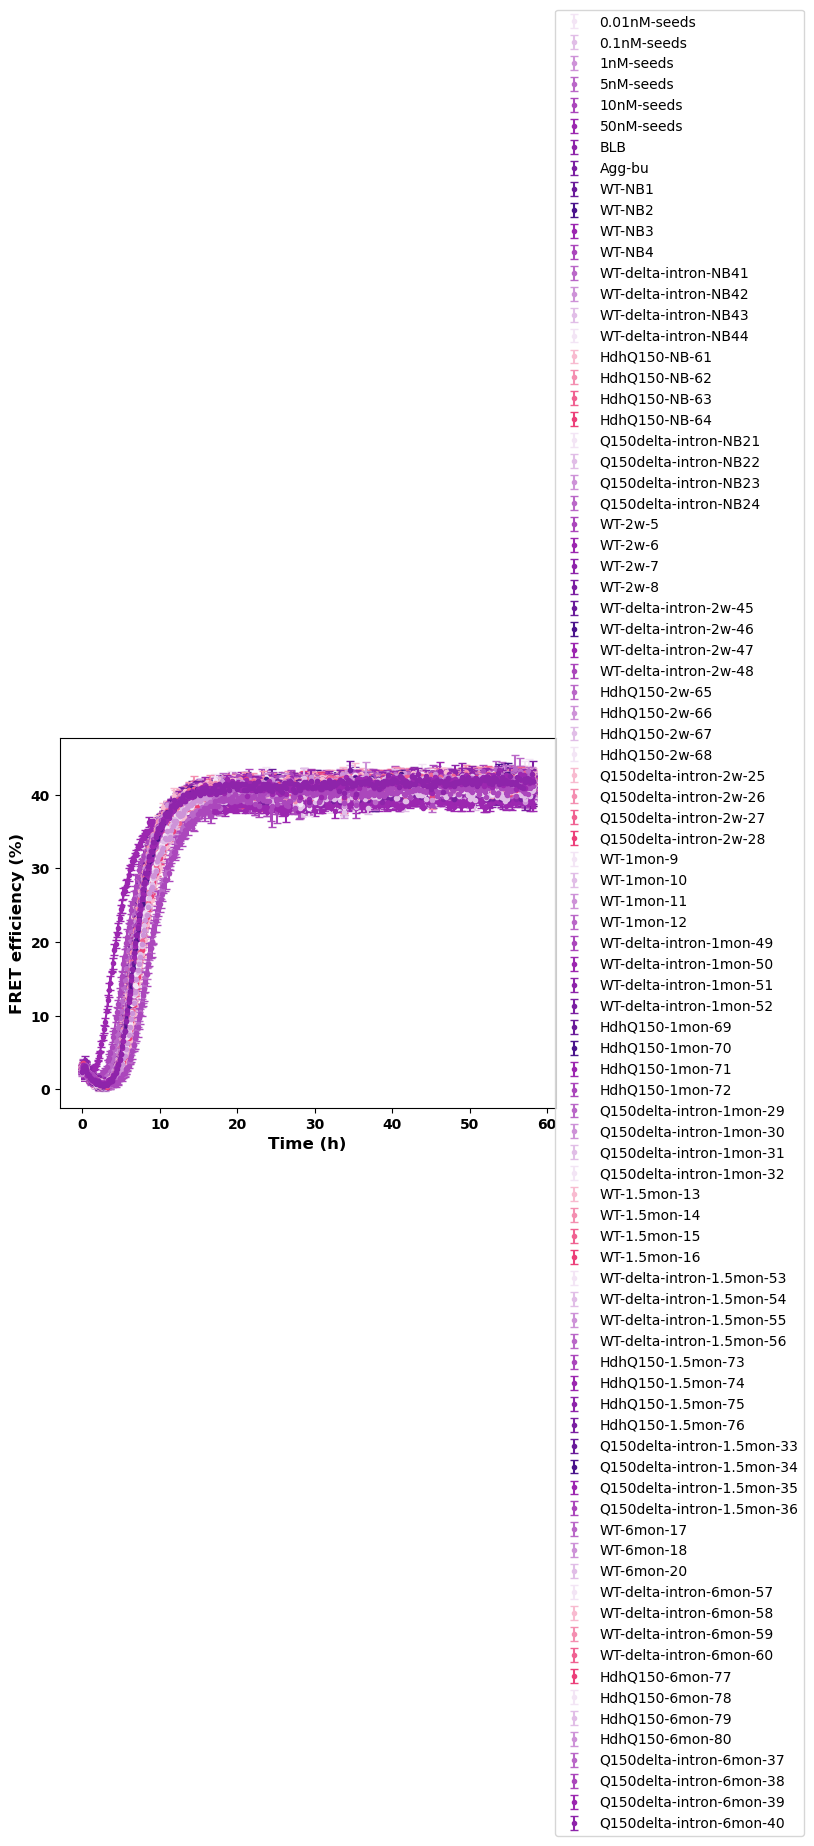

In [25]:
"""
Plot the data
"""
# Define the colormap

# Define a custom palette with MDC colors Blue, Dark Blue, Dark Red, Dark Teal, Light Blue, Light Red, Light Teal, Red, Teal 
custom_palette = ['#1e3791', '#141955', '#780050', '#005055', '#87aadc', '#faafaf', '#9bd7d2', '#eb2d4b', '#00ac8c']
#custom_palette = ['#1e3791', '#00ac8c']

custom_palette = [
    '#f3e5f5',  # Light Purple
    '#e1bee7',
    '#ce93d8',
    '#ba68c8',
    '#ab47bc',
    '#9c27b0',
    '#8e24aa',
    '#7b1fa2',
    '#6a1b9a',
    '#4a148c',
    '#9c27b0',
    '#ab47bc',
    '#ba68c8',
    '#ce93d8',
    '#e1bee7',
    '#f3e5f5',
    '#f8bbd0',
    '#f48fb1',
    '#f06292',
    '#ec407a'
]


# Check if custom_palette is defined
use_custom_palette = 'custom_palette' in locals()

# ... or used one from the system
#palette = cm.viridis
#palette = cm.gist_stern
#palette = cm.brg
#palette = cm.jet
#palette = cm.hot


#for column in filtered_exp:
for i, column in enumerate(exp_fret):
    if use_custom_palette:
        color = custom_palette[i % len(custom_palette)]  # Cycle through custom colors
    else:
        color = cm.viridis(i / len(exp_fret))  # Use viridis colormap
    
    plt.errorbar(frase_plot['time'], frase_plot[f'{column}'], yerr=frase_plot[f'std_{column}'], label = column, capsize=3, fmt='.', linestyle='None', color=color)
    plt.plot(frase_plot['time'], fitted_curves_dict[f'{column}'], color=color)

frase_plot.to_csv('plot_values.csv', index=False)
fit_pd = pd.DataFrame(fitted_curves_dict)
fit_pd.to_csv('fit.csv', index=False)

plt.xlabel('Time (h)', fontweight='bold', size=12)
plt.ylabel('FRET efficiency (%)', fontweight='bold', size=12)
plt.yticks(fontweight='bold', size=10)
plt.xticks(fontweight='bold', size=10)
plt.legend(loc='center', bbox_to_anchor=(1.25, 0.5))

plt.savefig('frase.svg')
plt.savefig('frase.png')
plt.show()